# Table of contents
1. [Divvy Bike](#DivvyBike)
    1. [Top 5 stations with the most starts (showing # of starts)](#DivvyBike1)
    1. [Trip duration by user type](#DivvyBike2)
    1. [Most popular trips based on start station and stop station](#DivvyBike3)
    1. [Rider performance by Gender and Age](#DivvyBike4)
    1. [What is the busiest bike in Chicago in 2017?](#DivvyBike5)
    1. [Model to predict trip length](#DivvyBike6)
2. [Yelp NLP](#YelpNLP)
    1. [Top 10 Cuisine types](#YelpNLP1)
    1. [Top key words/phrases for the top 10 Cuisine types](#YelpNLP2)
    1. [Topic modeling](#YelpNLP3)
    1. [Sentiment & Correlation](#YelpNLP4)


In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from haversine import haversine, Unit
from sklearn.linear_model import LinearRegression
import re
import json
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import wordnet as wn
import gensim
import pyLDAvis.gensim

import warnings
warnings.filterwarnings('ignore')

# Divvy Bike <a name="DivvyBike"></a>

## Importing Data and Cleaning
### Trip Data
#### Import four quarter trip data files

In [2]:
df_q1 = pd.read_csv(os.path.join('data', 'Divvy_Trips_2017_Q1.csv'))
df_q2 = pd.read_csv(os.path.join('data', 'Divvy_Trips_2017_Q2.csv'))
df_q3 = pd.read_csv(os.path.join('data', 'Divvy_Trips_2017_Q3.csv'))
df_q4 = pd.read_csv(os.path.join('data', 'Divvy_Trips_2017_Q4.csv'))

df_q1.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0
2,13518903,3/31/2017 23:55:33,4/1/2017 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0
4,13518901,3/31/2017 23:53:33,4/1/2017 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0


#### Concatenate four quarters data into single DF 

In [3]:
print(df_q1.shape)
print(df_q2.shape)
print(df_q3.shape)
print(df_q4.shape)

print('Total Rows =',df_q1.shape[0]+df_q2.shape[0]+df_q3.shape[0]+df_q4.shape[0])

(431691, 12)
(1119814, 12)
(1608270, 12)
(669239, 12)
Total Rows = 3829014


In [4]:
df = pd.concat([df_q1,df_q2,df_q3,df_q4])
df.shape

(3829014, 12)

#### Remove Duplicate Trips

In [5]:
df.drop_duplicates(keep=False,inplace=True) 
df.shape

(3828992, 12)

### Station Data
#### Import Station Files

In [6]:
df_s1 = pd.read_csv(os.path.join('data', 'Divvy_Stations_2017_Q1Q2.csv'))
df_s2 = pd.read_csv(os.path.join('data', 'Divvy_Stations_2017_Q3Q4.csv'))
#df_s2.head()
print(df_s1.shape)
print(df_s2.shape)

(582, 7)
(585, 7)


In [7]:
df_stations = df_s2

## 1)	Top 5 stations with the most starts (showing # of starts) <a name="DivvyBike1"></a>

In [8]:
top_5_stations = df['from_station_name'].value_counts().head(5)
top_5_stations

Streeter Dr & Grand Ave         97567
Lake Shore Dr & Monroe St       53396
Canal St & Adams St             50911
Clinton St & Washington Blvd    49832
Theater on the Lake             47908
Name: from_station_name, dtype: int64

In [9]:
top_5_stations_id = df['from_station_id'].value_counts().head(5)
top_5_stations_id

35     97567
76     53396
192    50911
91     49832
177    47908
Name: from_station_id, dtype: int64

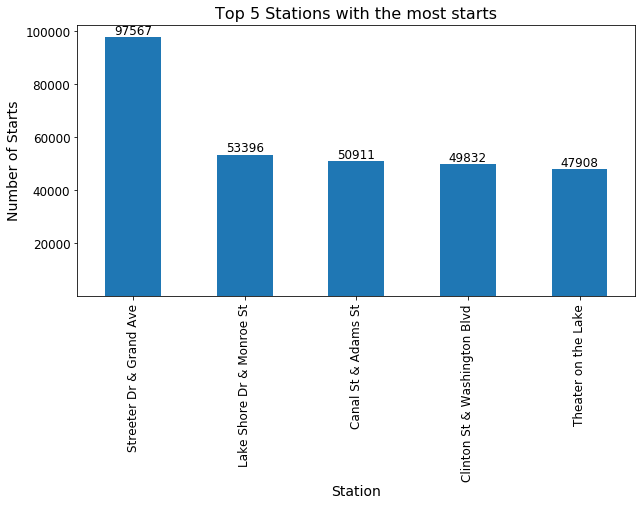

In [10]:
ax = top_5_stations.plot(kind='bar', figsize=(10, 5), fontsize=12) #legend=True
plt.title('Top 5 Stations with the most starts', fontsize=16)
plt.ylabel('Number of Starts', fontsize=14)
plt.xlabel('Station', fontsize=14)

ax = plt.gca()
y_max = top_5_stations
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.0f}'.format(p.get_height()), fontsize=12, color='black', ha='center', va='bottom')
    
plt.show()

## 2)	Trip duration by user type <a name="DivvyBike2"></a>

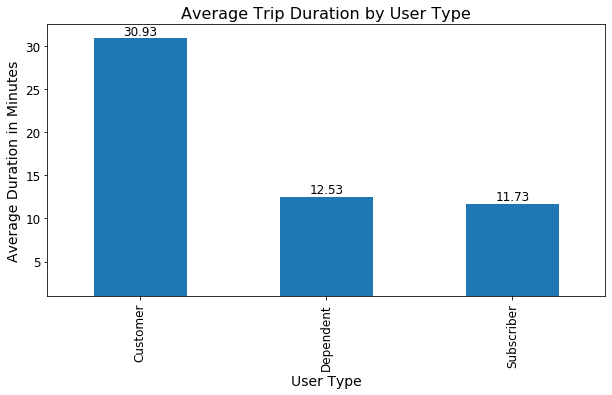

In [11]:
trip_duration_usertype_mean = df.groupby(['usertype'])['tripduration'].mean()/60

ax = trip_duration_usertype_mean.plot(kind='bar', figsize=(10, 5), fontsize=12) #legend=True
plt.title('Average Trip Duration by User Type', fontsize=16)
plt.ylabel('Average Duration in Minutes', fontsize=14)
plt.xlabel('User Type', fontsize=14)

ax = plt.gca()
y_max = trip_duration_usertype_mean
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), fontsize=12, color='black', ha='center', va='bottom')
    
plt.show()

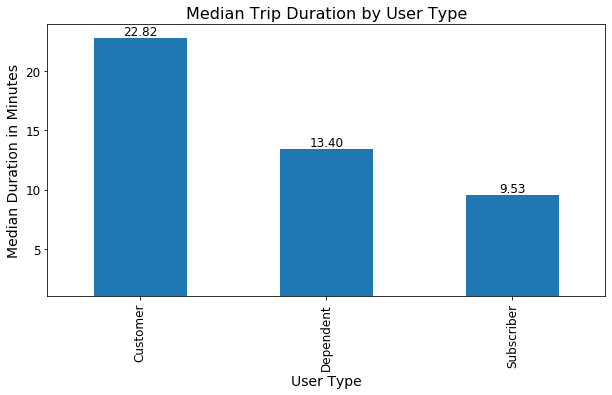

In [12]:
trip_duration_usertype_median = df.groupby(['usertype'])['tripduration'].median()/60

ax = trip_duration_usertype_median.plot(kind='bar', figsize=(10, 5), fontsize=12) #legend=True
plt.title('Median Trip Duration by User Type', fontsize=16)
plt.ylabel('Median Duration in Minutes', fontsize=14)
plt.xlabel('User Type', fontsize=14)

ax = plt.gca()
y_max = trip_duration_usertype_median
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), fontsize=12, color='black', ha='center', va='bottom')
    
plt.show()

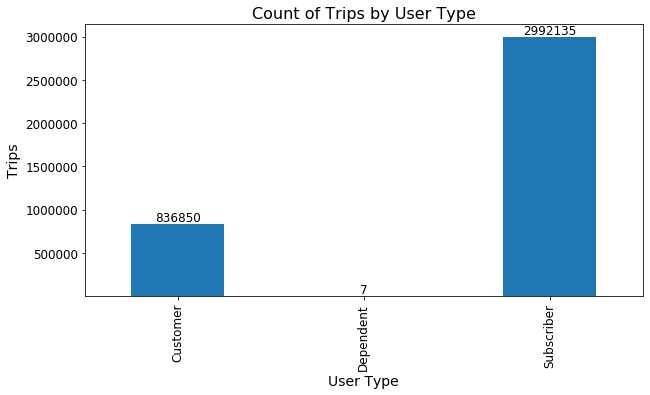

In [13]:
trip_count_usertype_trips = df.groupby(['usertype'])['tripduration'].count()

ax = trip_count_usertype_trips.plot(kind='bar', figsize=(10, 5), fontsize=12) #legend=True
plt.title('Count of Trips by User Type', fontsize=16)
plt.ylabel('Trips', fontsize=14)
plt.xlabel('User Type', fontsize=14)

ax = plt.gca()
y_max = trip_count_usertype_trips
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.0f}'.format(p.get_height()), fontsize=12, color='black', ha='center', va='bottom')
    
plt.show()

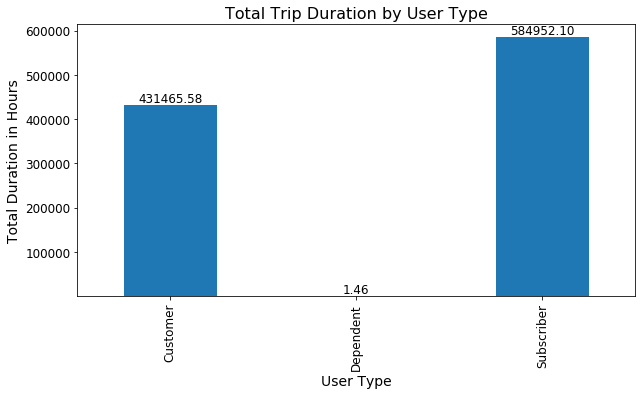

In [14]:
trip_duration_usertype_trips_total = df.groupby(['usertype'])['tripduration'].sum()/60/60

ax = trip_duration_usertype_trips_total.plot(kind='bar', figsize=(10, 5), fontsize=12) #legend=True
plt.title('Total Trip Duration by User Type', fontsize=16)
plt.ylabel('Total Duration in Hours', fontsize=14)
plt.xlabel('User Type', fontsize=14)

ax = plt.gca()
y_max = trip_duration_usertype_trips_total
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), fontsize=12, color='black', ha='center', va='bottom')
    
plt.show()

## 3)	Most popular trips based on start station and stop station <a name="DivvyBike3"></a>

In [15]:
most_popular_trips = df.groupby(['from_station_name','to_station_name']).size().reset_index(name='Count').sort_values('Count', ascending=False)
most_popular_trips.head(5)

,from_station_name,to_station_name,Count
50585,Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,12171
87780,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,10042
87781,Streeter Dr & Grand Ave,Theater on the Lake,8180
87634,Streeter Dr & Grand Ave,Lake Shore Dr & North Blvd,7993
50930,Lake Shore Dr & North Blvd,Streeter Dr & Grand Ave,7226


## 4)	Rider performance by Gender and Age based on avg trip distance (station to station), median speed (distance traveled / trip duration) <a name="DivvyBike4"></a>

Distance is based on the distance from starting station to ending station

#### Removing rides that start and end in the same station

In [16]:
mask = df['from_station_id'] != df['to_station_id']
df_rider_performance_data = df[mask]

#### Creating a dictionary of stations and coordinates for faster mapping to df

In [17]:
df_stations['coordinates'] = list(zip(df_stations.latitude, df_stations.longitude))
station_dict = dict(zip(df_stations.id, df_stations.coordinates))
df_stations.head()

,id,name,city,latitude,longitude,dpcapacity,online_date,coordinates
0,2,Buckingham Fountain,Chicago,41.876393,-87.620328,27,6/10/13 10:43,"(41.876393, -87.620328)"
1,3,Shedd Aquarium,Chicago,41.867226,-87.615355,55,6/10/13 10:44,"(41.86722596, -87.61535539)"
2,4,Burnham Harbor,Chicago,41.856268,-87.613348,23,6/10/13 10:46,"(41.856268, -87.613348)"
3,5,State St & Harrison St,Chicago,41.874053,-87.627716,23,6/10/13 10:46,"(41.874053, -87.627716)"
4,6,Dusable Harbor,Chicago,41.885041,-87.612794,39,6/10/13 11:18,"(41.885040999999994, -87.612794)"


#### Creates from_station_coordinates column and to_station_coordinates column 

In [18]:
def coordinate_of_station (f): 
    return (station_dict[f])

df_rider_performance_data['from_station_coordinates'] = df_rider_performance_data['from_station_id'].apply(coordinate_of_station)
df_rider_performance_data['to_station_coordinates'] = df_rider_performance_data['to_station_id'].apply(coordinate_of_station)

#### Calculating distance between stations (start, end stations) for each ride

In [19]:
def calc_trip_distance (from_coord, to_coord): 
    #return (haversine(row['from_station_coordinates'],row['to_station_coordinates']))
    return (haversine(from_coord,to_coord, unit=Unit.MILES))

df_rider_performance_data['trip_distance'] = df_rider_performance_data.apply(lambda row: calc_trip_distance(row['from_station_coordinates'], 
                                                              row['to_station_coordinates']), axis=1)

#### Calculating speed for each trip based on distance between stations and duration of trip

In [20]:
def calc_trip_speed (distance, duration): 
    return ((distance * 60) / (duration/60))

df_rider_performance_data['speed_mph'] = df_rider_performance_data.apply(lambda row: calc_trip_speed(row['trip_distance'], 
                                                   row['tripduration']), axis=1)

#### Calculating age (2017 - birth year)

In [21]:
df_rider_performance_data['age'] = 2017 - df_rider_performance_data['birthyear']

#### Plot Rider Performance

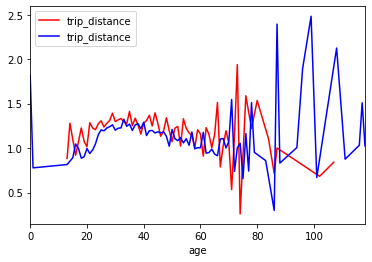

In [22]:
df_distance_grouby = df_rider_performance_data.groupby(['gender','age'], as_index=False)['trip_distance'].mean()

df_distance_grouby_female = df_distance_grouby[df_distance_grouby['gender'] == 'Female'].drop(columns=['gender'])
df_distance_grouby_male = df_distance_grouby[df_distance_grouby['gender'] == 'Male'].drop(columns=['gender'])

ax = plt.gca()
df_distance_grouby_female.plot(kind='line',x='age',y='trip_distance', color='red', ax=ax)
df_distance_grouby_male.plot(kind='line',x='age',y='trip_distance', color='blue', ax=ax)
plt.show()


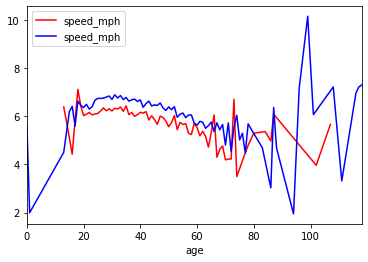

In [23]:
df_speed_grouby = df_rider_performance_data.groupby(['gender','age'], as_index=False)['speed_mph'].median()

df_speed_grouby_female = df_speed_grouby[df_speed_grouby['gender'] == 'Female'].drop(columns=['gender'])
df_speed_grouby_male = df_speed_grouby[df_speed_grouby['gender'] == 'Male'].drop(columns=['gender'])

ax = plt.gca()
df_speed_grouby_female.plot(kind='line',x='age',y='speed_mph', color='red', ax=ax)
df_speed_grouby_male.plot(kind='line',x='age',y='speed_mph', color='blue', ax=ax)
plt.show()

#### Bin Age Groups

In [24]:
df_rider_performance_data.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,from_station_coordinates,to_station_coordinates,trip_distance,speed_mph,age
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,"(41.885637, -87.641823)","(41.855136, -87.654127)",2.200447,9.243417,28.0
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,"(41.891465999999994, -87.626761)","(41.890359000000004, -87.617532)",0.480810,7.334393,27.0
2,13518903,3/31/2017 23:55:33,4/1/2017 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0,"(42.015962, -87.66856999999999)","(42.009074, -87.67419)",0.556537,5.757281,38.0
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,"(41.893992, -87.62931800000001)","(41.894503, -87.61785400000001)",0.590669,7.383359,32.0
4,13518901,3/31/2017 23:53:33,4/1/2017 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0,"(41.92154, -87.653818)","(41.908537, -87.648627)",0.937227,8.130162,28.0


In [25]:
#http://www.datasciencemadesimple.com/binning-or-bucketing-of-column-in-pandas-python-2/

bins = [17, 25, 35, 45, 55, 65, 70]
df_rider_performance_data['age_group'] = pd.cut(df_rider_performance_data['age'], bins)
df_rider_performance_data.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,from_station_coordinates,to_station_coordinates,trip_distance,speed_mph,age,age_group
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,"(41.885637, -87.641823)","(41.855136, -87.654127)",2.200447,9.243417,28.0,"(25, 35]"
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,"(41.891465999999994, -87.626761)","(41.890359000000004, -87.617532)",0.480810,7.334393,27.0,"(25, 35]"
2,13518903,3/31/2017 23:55:33,4/1/2017 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0,"(42.015962, -87.66856999999999)","(42.009074, -87.67419)",0.556537,5.757281,38.0,"(35, 45]"
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,"(41.893992, -87.62931800000001)","(41.894503, -87.61785400000001)",0.590669,7.383359,32.0,"(25, 35]"
4,13518901,3/31/2017 23:53:33,4/1/2017 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0,"(41.92154, -87.653818)","(41.908537, -87.648627)",0.937227,8.130162,28.0,"(25, 35]"


In [26]:
df_rider_performance_data.groupby(['gender', 'age_group']).agg(median_speed=('speed_mph', 'median'), avg_distance=('trip_distance', 'mean'),)

median_speed  avg_distance
gender age_group                            
Female (17, 25]       6.115334      1.254441
       (25, 35]       6.296069      1.310329
       (35, 45]       6.067444      1.279189
       (45, 55]       5.766373      1.192859
       (55, 65]       5.385137      1.110877
       (65, 70]       4.930709      1.146180
Male   (17, 25]       6.598445      1.118305
       (25, 35]       6.790378      1.238980
       (35, 45]       6.596099      1.218950
       (45, 55]       6.303980      1.121446
       (55, 65]       5.829150      1.042199
       (65, 70]       5.495970      1.019229

### 5)	What is the busiest bike in Chicago in 2017? How many times was it used? How many minutes was it in use? <a name="DivvyBike5"></a>
#### Busiest Bike based on Time in Use

In [27]:
busiest_bike_df_time = df.groupby(['bikeid']).agg(total_time_ridden=('tripduration', 'sum'),num_of_trips=('bikeid', 'count'),).sort_values('total_time_ridden', ascending=False).reset_index()
busiest_bike_df_time['total_time_ridden'] = round(busiest_bike_df_time['total_time_ridden']/60, 2)
busiest_bike_df_time.head()


,bikeid,total_time_ridden,num_of_trips
0,2565,22526.42,1489
1,5880,20693.90,1177
2,5293,19865.42,1049
3,5479,19569.18,1044
4,5731,19356.55,1027


#### Busiest Bike based on Total Trip Count

In [28]:
busiest_bike_df_count = df.groupby(['bikeid']).agg(num_of_trips=('bikeid', 'count'), total_time_ridden=('tripduration', 'sum'),).sort_values('num_of_trips', ascending=False).reset_index()
busiest_bike_df_count['total_time_ridden'] = round(busiest_bike_df_count['total_time_ridden']/60, 2)
busiest_bike_df_count.head()


,bikeid,num_of_trips,total_time_ridden
0,2565,1489,22526.42
1,3308,1234,17662.63
2,3489,1225,17617.47
3,3128,1210,18244.30
4,5880,1177,20693.90


### Model to predict trip length <a name="DivvyBike6"></a>

Only taking account of trips:
- that start and end in different stations
- that are the top 1000 fastest trips based on trip_distance - this way we can only take into account trips that are "direct" where the rider is focused on getting to the destination instead of visiting other destinations

In [29]:
df_model_data = df_rider_performance_data[['trip_distance','tripduration']]

#mask = df_model_data['tripduration'] < 10800 # 3 hours

#df_model_data = df_model_data[mask]#.shape
df_model_data.shape

(3707683, 2)

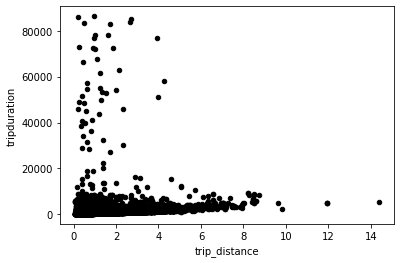

In [30]:
ax = plt.gca()
df_model_data.head(100000).plot(kind='scatter',x='trip_distance',y='tripduration', color='black', ax=ax)
plt.show()

#### Baseline model

In [31]:
X = df_model_data[['trip_distance']]
y = df_model_data[['tripduration']]

reg = LinearRegression().fit(X, y)

reg.score(X, y)

0.09457947937144072

#### Remove IQR outliers

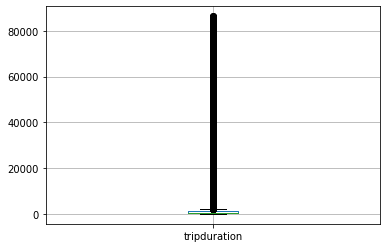

In [32]:
#boxplot = df_model_data.boxplot(column=['trip_distance', 'tripduration'])
boxplot = df_model_data.boxplot(column=['tripduration'])#, 'tripduration'])

In [33]:
Q1 = df_model_data['tripduration'].quantile(0.25)
Q3 = df_model_data['tripduration'].quantile(0.75)
IQR = Q3 - Q1

df_model_data = df_model_data[(df_model_data['tripduration'] >= (Q1 - 1.5 * IQR)) & 
                              (df_model_data['tripduration'] <= (Q3 + 1.5 * IQR))]

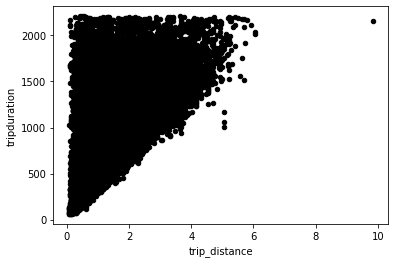

In [34]:
ax = plt.gca()
df_model_data.head(100000).plot(kind='scatter',x='trip_distance',y='tripduration', color='black', ax=ax)
plt.show()

In [35]:
X = df_model_data[['trip_distance']]
y = df_model_data[['tripduration']]

reg = LinearRegression().fit(X, y)

reg.score(X, y)

0.5190631597935814

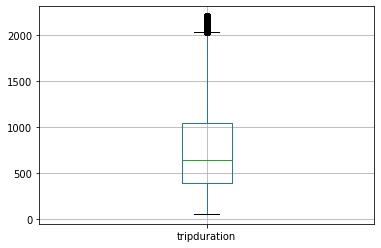

In [36]:
boxplot = df_model_data.boxplot(column=['tripduration'])#, 'tripduration'])

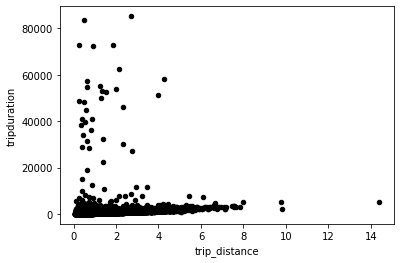

In [37]:
df_model_data_subscribers = df_rider_performance_data[['trip_distance','tripduration','usertype']]
mask = df_model_data_subscribers['usertype'] == 'Subscriber'
df_model_data_subscribers = df_model_data_subscribers[mask]
df_model_data_subscribers.shape

ax = plt.gca()
df_model_data_subscribers.head(100000).plot(kind='scatter',x='trip_distance',y='tripduration', color='black', ax=ax)
plt.show()

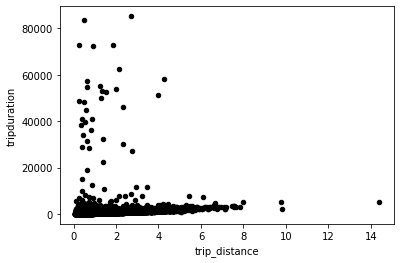

In [38]:
mask = df_rider_performance_data['usertype'] == 'Subscriber'
df_model_data_subscribers = df_rider_performance_data[['trip_distance','tripduration','usertype']][mask]

ax = plt.gca()
df_model_data_subscribers.head(100000).plot(kind='scatter',x='trip_distance',y='tripduration', color='black', ax=ax)
plt.show()

In [39]:
Q1 = df_model_data_subscribers['tripduration'].quantile(0.25)
Q3 = df_model_data_subscribers['tripduration'].quantile(0.75)
IQR = Q3 - Q1

df_model_data_subscribers = df_model_data_subscribers[
                                (df_model_data_subscribers['tripduration'] >= (Q1 - 1.5 * IQR)) & 
                                (df_model_data_subscribers['tripduration'] <= (Q3 + 1.5 * IQR))]

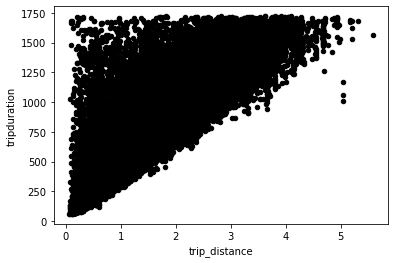

In [40]:
ax = plt.gca()
df_model_data_subscribers.head(100000).plot(kind='scatter',x='trip_distance',y='tripduration', color='black', ax=ax)
plt.show()

In [41]:
X = df_model_data_subscribers[['trip_distance']]
y = df_model_data_subscribers[['tripduration']]

reg = LinearRegression().fit(X, y)

reg.score(X, y)

0.7170886656896844

In [42]:
X = df_model_data_subscribers[['trip_distance']].head(10000)
y = df_model_data_subscribers[['tripduration']].head(10000)

In [43]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

logisticRegr.fit(X, y)
logisticRegr.score(X, y)

0.0071

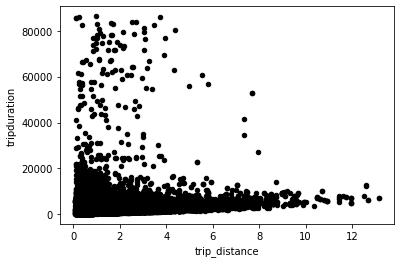

In [44]:
mask = df_rider_performance_data['usertype'] == 'Customer'
df_model_data_customers = df_rider_performance_data[['trip_distance','tripduration','usertype']][mask]

ax = plt.gca()
df_model_data_customers.head(100000).plot(kind='scatter',x='trip_distance',y='tripduration', color='black', ax=ax)
plt.show()

# Yelp NLP <a name="YelpNLP"></a>

In [45]:
df_yelp_business = pd.read_json(os.path.join('data', 'business.json'), lines=True)
df_yelp_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."


In [46]:
df_yelp_checkin = pd.read_json(os.path.join('data', 'checkin.json'), lines=True)
df_yelp_checkin.head(2)

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."


In [47]:
df_yelp_business.shape

(192609, 14)

### Top 10 Cuisine types <a name="YelpNLP1"></a>
#### Create and apply function to make only 2017 checkins into list, then counting them

In [48]:
def checkin_in_2017 (f):
    #f = df_yelp_checkin.loc[0]['date']
    checkin_list = f.split(', ')

    # https://stackoverflow.com/questions/44517191/how-to-find-the-python-list-item-that-start-with
    checkin_list = [i for i in checkin_list if i.startswith('2017')]
    return checkin_list

df_yelp_checkin['2017_checkins'] = df_yelp_checkin['date'].apply(checkin_in_2017)
df_yelp_checkin['count'] = df_yelp_checkin['2017_checkins'].apply(len)

df_yelp_checkin.head(2)


,business_id,date,2017_checkins,count
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016...","[2017-04-20 18:39:06, 2017-05-03 17:58:02]",2
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012...","[2017-01-09 01:07:12, 2017-01-15 03:53:00, 201...",35


In [49]:
df_yelp_business = df_yelp_business.merge(df_yelp_checkin, left_on='business_id', right_on='business_id')
df_yelp_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,date,2017_checkins,count
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None,"2012-06-16 14:53:33, 2013-05-19 16:52:24, 2013...",[],0
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...","2010-07-05 16:56:31, 2010-12-21 20:30:01, 2010...","[2017-01-02 16:13:42, 2017-01-07 23:39:44, 201...",51


#### Selecting Businesses that have categories within the restaurant hierarchy 
* based on https://www.yelp.com/developers/documentation/v3/category_list

In [50]:
#restaurant categories pulled from https://www.yelp.com/developers/documentation/v3/category_list

restaurant_categories = '''Restaurants (restaurants)
Afghan (afghani)
African (african)
Senegalese (senegalese)
South African (southafrican)
American (New) (newamerican)
American (Traditional) (tradamerican)
Arabian (arabian)
Argentine (argentine)
Armenian (armenian)
Asian Fusion (asianfusion)
Australian (australian)
Austrian (austrian)
Bangladeshi (bangladeshi)
Barbeque (bbq)
Basque (basque)
Belgian (belgian)
Brasseries (brasseries)
Brazilian (brazilian)
Breakfast & Brunch (breakfast_brunch)
Pancakes (pancakes)
British (british)
Buffets (buffets)
Bulgarian (bulgarian)
Burgers (burgers)
Burmese (burmese)
Cafes (cafes)
Themed Cafes (themedcafes)
Cafeteria (cafeteria)
Cajun/Creole (cajun)
Cambodian (cambodian)
Caribbean (caribbean)
Dominican (dominican)
Haitian (haitian)
Puerto Rican (puertorican)
Trinidadian (trinidadian)
Catalan (catalan)
Cheesesteaks (cheesesteaks)
Chicken Shop (chickenshop)
Chicken Wings (chicken_wings)
Chinese (chinese)
Cantonese (cantonese)
Dim Sum (dimsum)
Hainan (hainan)
Shanghainese (shanghainese)
Szechuan (szechuan)
Comfort Food (comfortfood)
Creperies (creperies)
Cuban (cuban)
Czech (czech)
Delis (delis)
Diners (diners)
Dinner Theater (dinnertheater)
Eritrean (eritrean)
Ethiopian (ethiopian)
Fast Food (hotdogs)
Filipino (filipino)
Fish & Chips (fishnchips)
Fondue (fondue)
Food Court (food_court)
Food Stands (foodstands)
French (french)
Mauritius (mauritius)
Reunion (reunion)
Game Meat (gamemeat)
Gastropubs (gastropubs)
Georgian (georgian)
German (german)
Gluten-Free (gluten_free)
Greek (greek)
Guamanian (guamanian)
Halal (halal)
Hawaiian (hawaiian)
Himalayan/Nepalese (himalayan)
Honduran (honduran)
Hong Kong Style Cafe (hkcafe)
Hot Dogs (hotdog)
Hot Pot (hotpot)
Hungarian (hungarian)
Iberian (iberian)
Indian (indpak)
Indonesian (indonesian)
Irish (irish)
Italian (italian)
Calabrian (calabrian)
Sardinian (sardinian)
Sicilian (sicilian)
Tuscan (tuscan)
Japanese (japanese)
Conveyor Belt Sushi (conveyorsushi)
Izakaya (izakaya)
Japanese Curry (japacurry)
Ramen (ramen)
Teppanyaki (teppanyaki)
Kebab (kebab)
Korean (korean)
Kosher (kosher)
Laotian (laotian)
Latin American (latin)
Colombian (colombian)
Salvadoran (salvadoran)
Venezuelan (venezuelan)
Live/Raw Food (raw_food)
Malaysian (malaysian)
Mediterranean (mediterranean)
Falafel (falafel)
Mexican (mexican)
Tacos (tacos)
Middle Eastern (mideastern)
Egyptian (egyptian)
Lebanese (lebanese)
Modern European (modern_european)
Mongolian (mongolian)
Moroccan (moroccan)
New Mexican Cuisine (newmexican)
Nicaraguan (nicaraguan)
Noodles (noodles)
Pakistani (pakistani)
Pan Asian (panasian)
Persian/Iranian (persian)
Peruvian (peruvian)
Pizza (pizza)
Polish (polish)
Polynesian (polynesian)
Pop-Up Restaurants (popuprestaurants)
Portuguese (portuguese)
Poutineries (poutineries)
Russian (russian)
Salad (salad)
Sandwiches (sandwiches)
Scandinavian (scandinavian)
Scottish (scottish)
Seafood (seafood)
Singaporean (singaporean)
Slovakian (slovakian)
Somali (somali)
Soul Food (soulfood)
Soup (soup)
Southern (southern)
Spanish (spanish)
Sri Lankan (srilankan)
Steakhouses (steak)
Supper Clubs (supperclubs)
Sushi Bars (sushi)
Syrian (syrian)
Taiwanese (taiwanese)
Tapas Bars (tapas)
Tapas/Small Plates (tapasmallplates)
Tex-Mex (tex-mex)
Thai (thai)
Turkish (turkish)
Ukrainian (ukrainian)
Uzbek (uzbek)
Vegan (vegan)
Vegetarian (vegetarian)
Vietnamese (vietnamese)
Waffles (waffles)
Wraps(wraps)'''

#https://stackoverflow.com/questions/37528373/how-to-remove-all-text-between-the-outer-parentheses-in-a-string

restaurant_categories = re.sub(r'\(.*\)', '', restaurant_categories)
restaurant_categories_list = restaurant_categories.split(' \n')
restaurant_categories_list

['Restaurants',
 'Afghan',
 'African',
 'Senegalese',
 'South African',
 'American',
 'American',
 'Arabian',
 'Argentine',
 'Armenian',
 'Asian Fusion',
 'Australian',
 'Austrian',
 'Bangladeshi',
 'Barbeque',
 'Basque',
 'Belgian',
 'Brasseries',
 'Brazilian',
 'Breakfast & Brunch',
 'Pancakes',
 'British',
 'Buffets',
 'Bulgarian',
 'Burgers',
 'Burmese',
 'Cafes',
 'Themed Cafes',
 'Cafeteria',
 'Cajun/Creole',
 'Cambodian',
 'Caribbean',
 'Dominican',
 'Haitian',
 'Puerto Rican',
 'Trinidadian',
 'Catalan',
 'Cheesesteaks',
 'Chicken Shop',
 'Chicken Wings',
 'Chinese',
 'Cantonese',
 'Dim Sum',
 'Hainan',
 'Shanghainese',
 'Szechuan',
 'Comfort Food',
 'Creperies',
 'Cuban',
 'Czech',
 'Delis',
 'Diners',
 'Dinner Theater',
 'Eritrean',
 'Ethiopian',
 'Fast Food',
 'Filipino',
 'Fish & Chips',
 'Fondue',
 'Food Court',
 'Food Stands',
 'French',
 'Mauritius',
 'Reunion',
 'Game Meat',
 'Gastropubs',
 'Georgian',
 'German',
 'Gluten-Free',
 'Greek',
 'Guamanian',
 'Halal',
 'Hawai

In [51]:
mask = df_yelp_business['categories'].notnull() #& df_yelp_business['categories'].str.contains('Restaurants') <- works too
df_yelp_business[mask].head()

# function creates a column that indicates whether the business is a restaurant or not
def filter_restaurant_categories(f):
    if f is not None:
        category_list = f.split(', ')
        # https://thispointer.com/python-check-if-a-list-contains-all-the-elements-of-another-list/
        if any(elem in category_list  for elem in restaurant_categories_list):
            return True
    else:
        return False
    
df_yelp_business['is_restaurant'] = df_yelp_business['categories'].apply(filter_restaurant_categories)
mask=df_yelp_business['is_restaurant'] == True
df_yelp_business_restaurants = df_yelp_business[mask]

#### Getting categories and the associated checkins via dictionary

In [52]:
def count_categories (f, category_dict):
    if f['categories'] is not None:
        category_list = f['categories'].split(', ')
        #print(category_list)
        if 'American (New)' in category_list and 'American (Traditional)' in category_list:
            category_list.remove('American (New)')
            category_list.remove('American (Traditional)')
            category_list.append('American')
        elif 'American (New)' in category_list:
            category_list.remove('American (New)')
            category_list.append('American')
        elif 'American (Traditional)' in category_list:
            category_list.remove('American (Traditional)')
            category_list.append('American')
            
        for category in category_list:
            if not category in category_dict:
                category_dict[category] = f['count']
            else:
                category_dict[category] += f['count']
    
    
category_dict = {}

df_yelp_business_restaurants.apply(count_categories,category_dict = category_dict, axis=1)

1         None
2         None
10        None
12        None
16        None
          ... 
161930    None
161931    None
161933    None
161939    None
161946    None
Length: 57402, dtype: object

#### Converting category and checkin dictionary to DataFrame

In [53]:
#https://eulertech.wordpress.com/2017/11/28/pandas-valueerror-if-using-all-scalar-values-you-must-pass-an-index/

df_category_checkin = pd.DataFrame(list(category_dict.items()), columns=['category', 'checkins'])
df_category_checkin.sort_values(by = ['checkins'], ascending = False).head()
#df_category_checkin.to_csv('checkin_count.csv')

,category,checkins
1,Restaurants,1465918
4,Food,450985
31,American,437747
24,Nightlife,367535
23,Bars,356538


### Top key words/phrases for the top 10 Cuisine types <a name="YelpNLP2"></a>

#### Parse through json, remove unneeded columns, keep only 2017 reviews

In [54]:
'''
#https://stackoverflow.com/questions/36606930/delete-an-element-in-a-json-object
with open('review_reduced_2017.json', 'w') as dest_file:
    with open(os.path.join('data', 'review.json'), 'r') as source_file:
        for line in source_file:
            element = json.loads(line.strip())
            if 'user_id' in element:
                del element['user_id']
            if 'useful' in element:
                del element['useful']
            if 'funny' in element:
                del element['funny']
            if 'cool' in element:
                del element['cool']
            if 'date' in element:
                if element['date'][:4] == '2017':
                    dest_file.write(json.dumps(element)+'\n')
'''

"\n#https://stackoverflow.com/questions/36606930/delete-an-element-in-a-json-object\nwith open('review_reduced_2017.json', 'w') as dest_file:\n    with open(os.path.join('data', 'review.json'), 'r') as source_file:\n        for line in source_file:\n            element = json.loads(line.strip())\n            if 'user_id' in element:\n                del element['user_id']\n            if 'useful' in element:\n                del element['useful']\n            if 'funny' in element:\n                del element['funny']\n            if 'cool' in element:\n                del element['cool']\n            if 'date' in element:\n                if element['date'][:4] == '2017':\n                    dest_file.write(json.dumps(element)+'\n')\n"

In [55]:
df_yelp_review = pd.read_json(os.path.join('data', 'review_reduced_2017.json'), lines = True)
#df_yelp_review.head()

In [56]:
df_yelp_review.shape

(1217673, 5)

#### Select restaurant reviews only

In [57]:
df_yelp_review_restaurant = df_yelp_review[df_yelp_review['business_id'].isin(list(df_yelp_business_restaurants['business_id']))]

In [58]:
df_yelp_review_restaurant.shape

(746821, 5)

In [59]:
df_yelp_review_restaurant.head()

,review_id,business_id,stars,text,date
1,-I5umRTkhw15RqpKMl_o1Q,mRUVMJkUGxrByzMQ2MuOpA,1,"Walked in around 4 on a Friday afternoon, we s...",2017-12-15 23:27:08
2,svK3nBU7Rk8VfGorlrN52A,YvrylyuWgbP90RgMqZQVnQ,5,You can't really find anything wrong with this...,2017-04-07 21:27:49
3,rEITo90tpyKmEfNDp3Ou3A,6lj2BJ4tJeu7db5asGHQ4w,5,We've been a huge Slim's fan since they opened...,2017-05-26 01:23:19
4,Amo5gZBvCuPc_tZNpHwtsA,qx6WhZ42eDKmBchZDax4dQ,5,"Our family LOVES the food here. Quick, friendl...",2017-03-27 01:14:37
5,IPw8yWiyqnfBzzWmypUHgg,Mem13A3C202RzT53npn4NA,5,If you are looking for the best pierogies in P...,2017-05-13 10:41:43


#### Map businesses to each of the top 10 cuisine
Output: dictionary with each cuisine and a list of all the businesses that are categorized in that cuisine

In [60]:
cuisine_list = ['American','Mexican','Japanese','Asian Fusion','Italian','Chinese','Korean','Mediterranean','Thai','Vietnamese']

In [61]:
def cuisine_businesses (f, cuisine_business_dict):
    
    if f['categories'] is not None:
        category_list = f['categories'].split(', ')
        #print(category_list)
        
        if 'American (New)' in category_list and 'American (Traditional)' in category_list:
            category_list.remove('American (New)')
            category_list.remove('American (Traditional)')
            category_list.append('American')
        elif 'American (New)' in category_list:
            category_list.remove('American (New)')
            category_list.append('American')
        elif 'American (Traditional)' in category_list:
            category_list.remove('American (Traditional)')
            category_list.append('American')
        
        for cuisine in set(cuisine_list).intersection(category_list):
            #print(category)
            if not cuisine in cuisine_business_dict:
                cuisine_business_dict[cuisine] = []
                cuisine_business_dict[cuisine].append(f['business_id'])
            else:
                cuisine_business_dict[cuisine].append(f['business_id'])
    
cuisine_business_dict = {}

df_yelp_business_restaurants.apply(cuisine_businesses,cuisine_business_dict = cuisine_business_dict, axis=1)

1         None
2         None
10        None
12        None
16        None
          ... 
161930    None
161931    None
161933    None
161939    None
161946    None
Length: 57402, dtype: object

In [62]:
for key, value in cuisine_business_dict.items() :
    print ((key), len(value))

Chinese 4292
Japanese 2652
Mexican 4517
Italian 4565
American 10451
Korean 910
Mediterranean 1756
Vietnamese 1257
Thai 1412
Asian Fusion 1907


#### Get Reviews for every business in every Cuisine and calculate word frequency for each cuisine, then generate wordcloud

In [63]:
def word_cloud_frequency (df):
    #review_text = ' '.join(df.text.tolist())

    df_word_frequency = pd.Series(' '.join(df.text.str.lower()).split()).value_counts().to_frame().reset_index()
    df_word_frequency.columns = ['word', 'frequency']

    english_stopwords = set(nltk.corpus.stopwords.words('english'))
    english_stopwords.add('-')
    df_word_frequency = df_word_frequency[~df_word_frequency['word'].isin(english_stopwords)].reset_index(drop=True)
    
    print(', '.join(df_word_frequency.head(30).word.tolist()))
    
    d = {}
    for a, x in df_word_frequency.values:
        d[a] = x

    wordcloud = WordCloud(max_words=100,
                          width = 800, 
                          height = 800,
                          background_color ='white',
                          stopwords = english_stopwords,
                          min_font_size = 10).generate_from_frequencies(frequencies=d)

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    
    return (df_word_frequency.head(30).word.tolist())
    

Chinese
food, place, good, like, chicken, chinese, service, ordered, get, would, great, one, really, order, restaurant, time, fried, go, also, rice, came, back, soup, beef, got, come, even, definitely, noodles, always


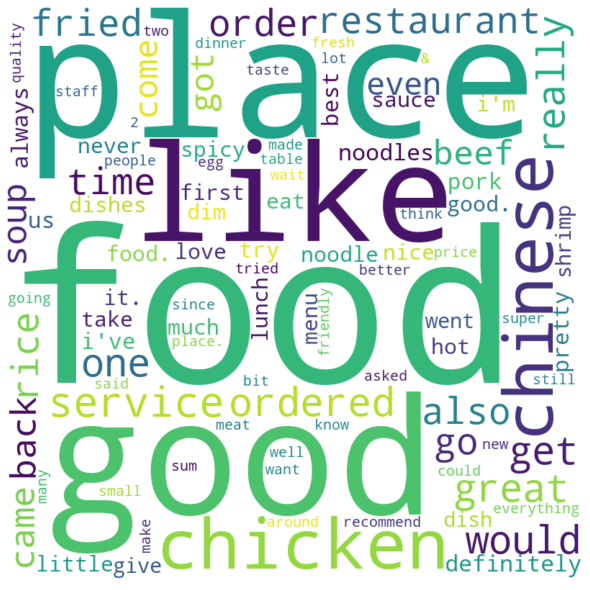

Japanese
sushi, food, place, good, great, like, service, really, one, would, get, ramen, ordered, time, also, came, back, go, definitely, got, come, restaurant, order, us, try, best, love, i've, always, even


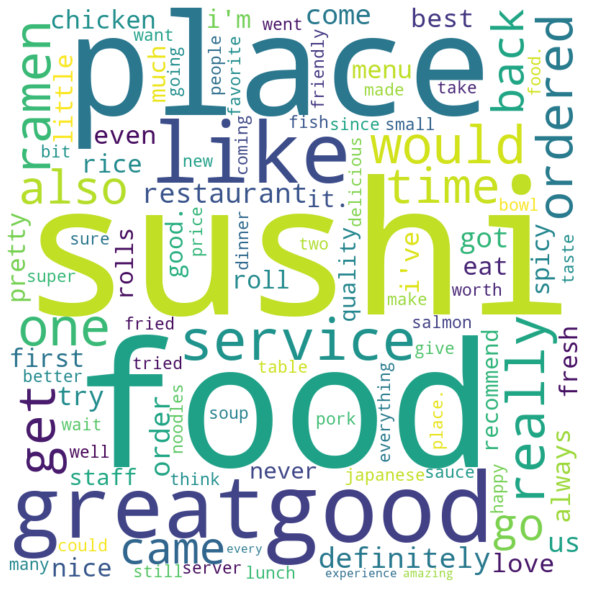

Mexican
food, place, good, great, tacos, like, service, get, one, mexican, really, would, ordered, time, go, back, taco, got, also, order, came, best, salsa, definitely, chicken, us, love, even, restaurant, always


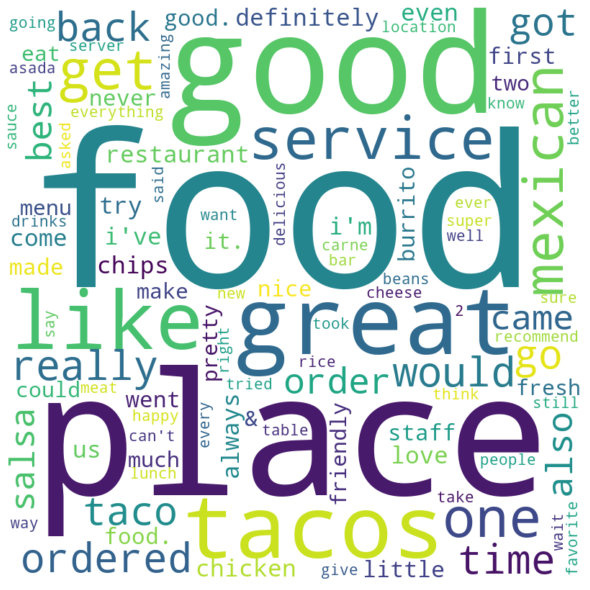

Italian
food, pizza, great, place, good, service, like, would, one, ordered, get, time, really, us, back, go, restaurant, italian, got, came, also, order, best, pasta, even, definitely, nice, love, always, sauce


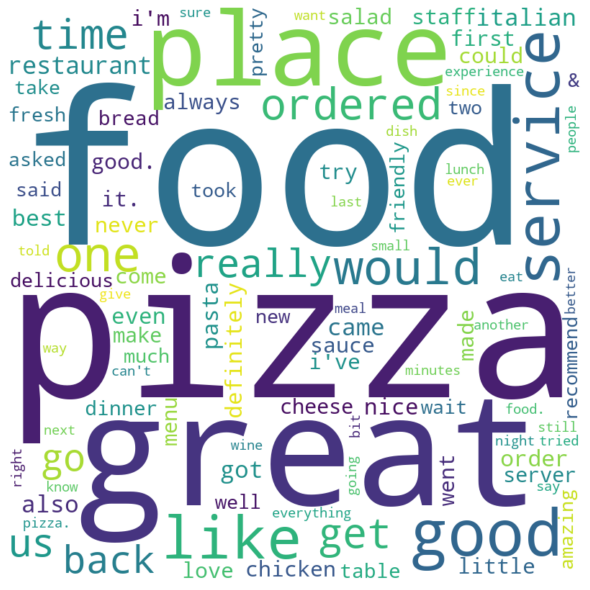

American
food, great, place, good, service, like, one, get, would, time, ordered, really, back, us, go, came, got, also, chicken, even, definitely, order, come, restaurant, nice, best, always, love, menu, first


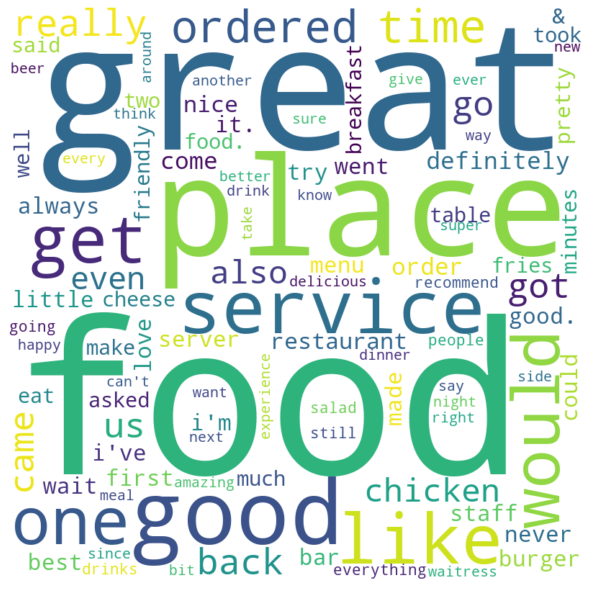

Korean
food, place, korean, good, service, like, great, really, would, one, get, also, time, came, ordered, chicken, come, back, definitely, us, go, pork, restaurant, got, meat, try, order, spicy, rice, side


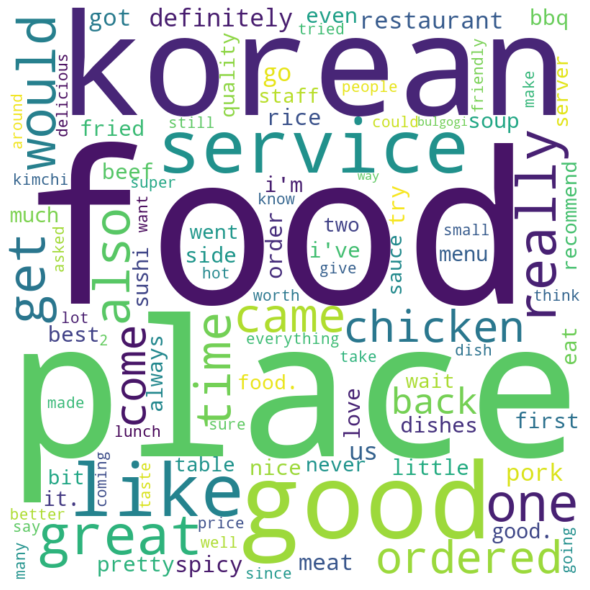

Mediterranean
food, place, great, good, chicken, service, like, one, really, ordered, would, get, time, go, back, restaurant, also, best, got, definitely, came, order, love, try, i've, greek, nice, always, salad, us


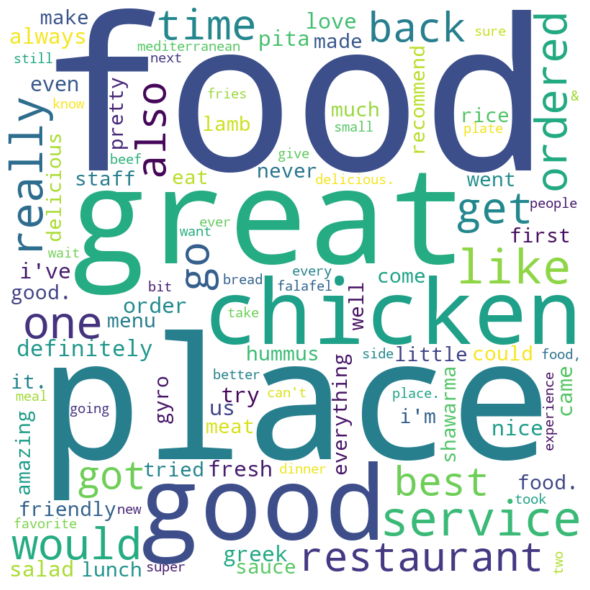

Vietnamese
pho, food, place, good, like, service, great, vietnamese, really, ordered, one, get, also, would, restaurant, go, beef, time, back, chicken, came, got, definitely, broth, come, spring, best, order, i've, try


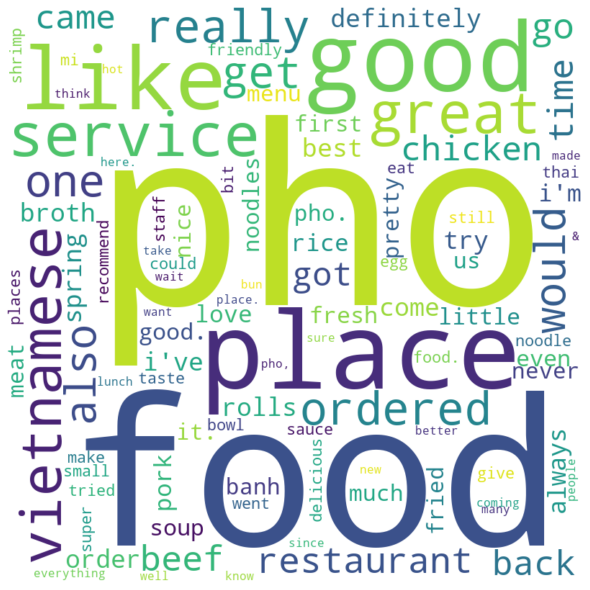

Thai
thai, food, place, good, pad, ordered, great, like, service, chicken, really, curry, would, one, restaurant, get, order, time, also, go, rice, back, i've, got, definitely, came, best, fried, love, always


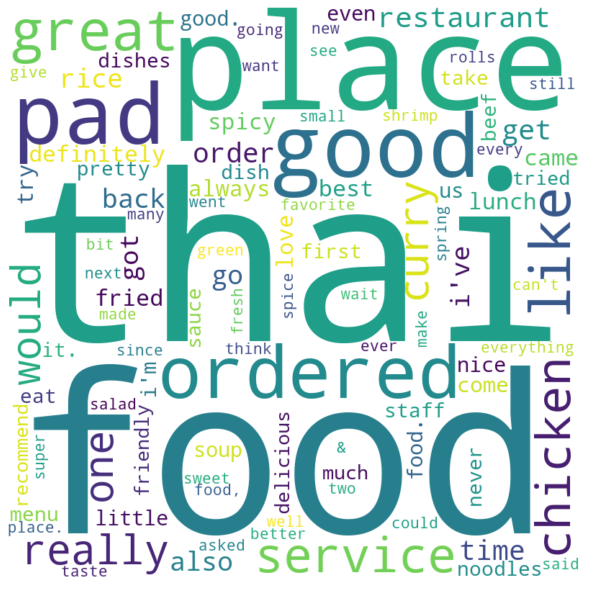

Asian Fusion
food, place, good, great, like, service, really, would, one, get, ordered, chicken, sushi, time, also, back, came, go, got, definitely, restaurant, order, try, come, us, rice, love, even, i've, best


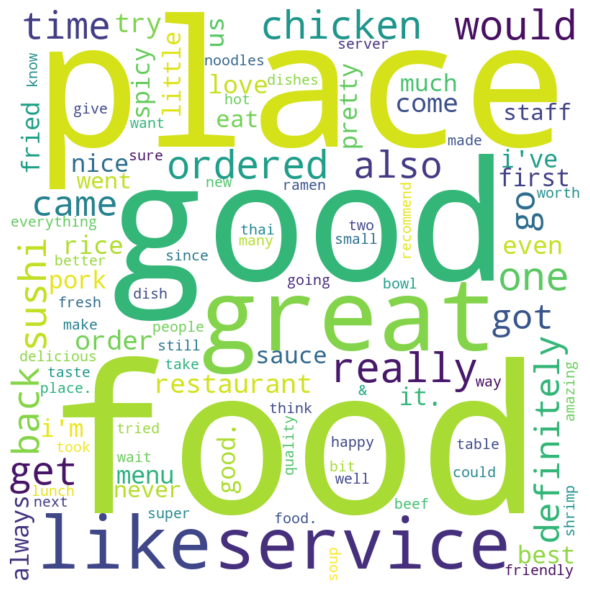

In [64]:
top_words_list = []
for key, value in cuisine_business_dict.items() :
    print(key)
    df_review_cuisine = df_yelp_review_restaurant[df_yelp_review_restaurant['business_id'].isin(cuisine_business_dict[key])]
    top_words = word_cloud_frequency (df_review_cuisine)
    top_words_list.append(top_words)

#### Find common keywords that every cuisine reviews use

In [65]:
# https://stackoverflow.com/questions/34582729/python-how-to-only-retain-elements-from-all-previous-sublists-while-iterating-o
common_words = set(top_words_list[0])
for s in top_words_list[1:]:
    common_words.intersection_update(s)
print ('Common words:',', '.join(list(common_words)))

for i in top_words_list:
    print(', '.join([x for x in i if x not in list(common_words)]))


Common words: food, got, ordered, also, restaurant, really, came, time, one, like, would, place, get, back, order, good, service, great, go, definitely
chicken, chinese, fried, rice, soup, beef, come, even, noodles, always
sushi, ramen, come, us, try, best, love, i've, always, even
tacos, mexican, taco, best, salsa, chicken, us, love, even, always
pizza, us, italian, best, pasta, even, nice, love, always, sauce
us, chicken, even, come, nice, best, always, love, menu, first
korean, chicken, come, us, pork, meat, try, spicy, rice, side
chicken, best, love, try, i've, greek, nice, always, salad, us
pho, vietnamese, beef, chicken, broth, come, spring, best, i've, try
thai, pad, chicken, curry, rice, i've, best, fried, love, always
chicken, sushi, try, come, us, rice, love, even, i've, best


### Topic modeling <a name="YelpNLP3"></a>

In [66]:
# Natural Language Text Processing with Python by Jonathan Mugan course

def tokenize(text):
    lda_tokens = word_tokenize(text)
    return lda_tokens

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else: 
        return lemma
english_stopwords = set(nltk.corpus.stopwords.words('english'))

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in english_stopwords]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


In [67]:
def text_tokens_prep (f, text_data):
    tokens = prepare_text_for_lda(f['text'])
    text_data.append(tokens)
    
text_data = []

df_yelp_review_restaurant.head(10000).apply(text_tokens_prep,text_data = text_data, axis=1)


1        None
2        None
3        None
4        None
5        None
         ... 
15997    None
15999    None
16000    None
16001    None
16002    None
Length: 10000, dtype: object

In [68]:
# create a dictionary from the data
from gensim import corpora
dictionary = corpora.Dictionary(text_data)

# convert to bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in text_data]


In [69]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word= dictionary, passes = 10)
ldamodel.save('model2.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word= dictionary, passes = 10)
ldamodel.save('model4.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=6, id2word= dictionary, passes = 10)
ldamodel.save('model6.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
    
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=8, id2word= dictionary, passes = 10)
ldamodel.save('model8.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
    
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word= dictionary, passes = 10)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.018*"place" + 0.015*"service" + 0.015*"order" + 0.011*"great"')
(1, '0.016*"place" + 0.012*"chicken" + 0.010*"order" + 0.010*"great"')
(0, '0.013*"noodle" + 0.010*"cream" + 0.008*"taste" + 0.008*"buffet"')
(1, '0.027*"order" + 0.015*"service" + 0.011*"burger" + 0.011*"would"')
(2, '0.027*"place" + 0.025*"great" + 0.016*"service" + 0.012*"restaurant"')
(3, '0.016*"chicken" + 0.013*"place" + 0.013*"order" + 0.010*"would"')
(0, '0.026*"order" + 0.014*"service" + 0.013*"would" + 0.012*"place"')
(1, '0.016*"place" + 0.010*"order" + 0.010*"chicken" + 0.009*"restaurant"')
(2, '0.020*"burger" + 0.018*"sauce" + 0.017*"chicken" + 0.013*"fries"')
(3, '0.036*"great" + 0.036*"place" + 0.024*"service" + 0.014*"always"')
(4, '0.017*"noodle" + 0.014*"place" + 0.010*"really" + 0.009*"would"')
(5, '0.003*"mignon" + 0.003*"filet" + 0.002*"minimal" + 0.002*"restaurant"')
(0, '0.018*"restaurant" + 0.016*"great" + 0.010*"service" + 0.009*"dinner"')
(1, '0.031*"ramen" + 0.015*"vegan" + 0.007*"Ramen" +

In [70]:
lda2 = gensim.models.ldamodel.LdaModel.load('model2.gensim')
lda_display2 = pyLDAvis.gensim.prepare(lda2,corpus,dictionary,sort_topics=False)
pyLDAvis.display(lda_display2)

In [71]:
lda4 = gensim.models.ldamodel.LdaModel.load('model4.gensim')
lda_display4 = pyLDAvis.gensim.prepare(lda4,corpus,dictionary,sort_topics=False)
pyLDAvis.display(lda_display4)

In [72]:
lda6 = gensim.models.ldamodel.LdaModel.load('model6.gensim')
lda_display6 = pyLDAvis.gensim.prepare(lda6,corpus,dictionary,sort_topics=False)
pyLDAvis.display(lda_display6)

In [73]:
lda8 = gensim.models.ldamodel.LdaModel.load('model8.gensim')
lda_display8 = pyLDAvis.gensim.prepare(lda8,corpus,dictionary,sort_topics=False)
pyLDAvis.display(lda_display8)

In [74]:
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display10 = pyLDAvis.gensim.prepare(lda10,corpus,dictionary,sort_topics=False)
pyLDAvis.display(lda_display10)

### Sentiment & Correlation <a name="YelpNLP4"></a>

#### Select top 10 restaurants based on number of check ins

In [75]:
top_10_business_by_checkin = df_yelp_business_restaurants.sort_values('count', ascending=False).head(10)
top_10_business_by_checkin = top_10_business_by_checkin[['business_id','name','count']]
top_10_business_by_checkin

,business_id,name,count
101306,hihud--QRriCYZw1zZvW4g,Gangnam Asian BBQ Dining,11081
101667,IZivKqtHyz4-ts8KsnvMrA,Kung Fu Tea,8715
46148,QXV3L_QFGj8r6nWX2kS2hA,Nacho Daddy,6901
75044,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,4693
78089,IhNASEZ3XnBHmuuVnWdIwA,Brew Tea Bar,3956
160649,3kdSl5mo9dWC4clrQjEDGg,Egg & I,3938
50710,eJKnymd0BywNPrJw1IuXVw,Nacho Daddy Downtown,3226
75241,5LNZ67Yw9RD6nf4_UhXOjw,The Cosmopolitan of Las Vegas,3143
143372,mU3vlAVzTxgmZUu6F4XixA,Momofuku Las Vegas,2576
2222,Wxxvi3LZbHNIDwJ-ZimtnA,The Venetian Las Vegas,2450


#### Mask out reviews from the 10 ten restaurants

In [76]:
df_yelp_top_10_review = df_yelp_review[df_yelp_review['business_id'].isin(list(top_10_business_by_checkin['business_id']))]
df_yelp_top_10_review.shape

(6488, 5)

#### Calculate sentiment on each review

In [77]:
'''
Notes: 

# https://github.com/cjhutto/vaderSentiment
positive sentiment: compound score >= 0.05
neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
negative sentiment: compound score <= -0.05
'''

def sentiment_analyzer_scores(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    return score['compound']

df_yelp_top_10_review['sentiment'] = df_yelp_top_10_review['text'].apply(sentiment_analyzer_scores)
df_yelp_top_10_review.head()

,review_id,business_id,stars,text,date,sentiment
160,pSU8m0PNKlw-JMOEr6bmqA,Wxxvi3LZbHNIDwJ-ZimtnA,3,This is a grand place in many ways; the lobby ...,2017-08-07 21:05:08,0.8058
1358,zapSZdjq5jWSwy97jIMDGw,Wxxvi3LZbHNIDwJ-ZimtnA,4,"The room looks nice... but for suites, there's...",2017-12-29 16:36:06,0.5267
1567,Vx0Dl8ANY5mDqpfu8uAaOg,Wxxvi3LZbHNIDwJ-ZimtnA,4,The rooms are nice and spacious. I like the lo...,2017-08-16 17:41:20,0.9661
1654,sDosVkc71DnA-X01vfOhIw,Wxxvi3LZbHNIDwJ-ZimtnA,5,It was my first time in Vegas and let me just ...,2017-07-28 19:05:39,0.9915
1805,YSy9F3KkN_4qDCFL1PmY4w,Wxxvi3LZbHNIDwJ-ZimtnA,5,Absolutely stunning inside. It was much more t...,2017-03-15 03:16:29,0.9500


#### Calculate average star rating and average sentiment for each business

In [78]:
business_avg_sentiment = df_yelp_top_10_review.groupby(['business_id']).agg(avg_stars=('stars', 'mean'),avg_sentiment=('sentiment', 'mean'),).reset_index()\


In [79]:
business_avg_sentiment = pd.merge(top_10_business_by_checkin, business_avg_sentiment, on='business_id')
business_avg_sentiment

,business_id,name,count,avg_stars,avg_sentiment
0,hihud--QRriCYZw1zZvW4g,Gangnam Asian BBQ Dining,11081,4.458689,0.791647
1,IZivKqtHyz4-ts8KsnvMrA,Kung Fu Tea,8715,4.468468,0.729564
2,QXV3L_QFGj8r6nWX2kS2hA,Nacho Daddy,6901,4.317330,0.785049
3,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,4693,3.674051,0.659237
4,IhNASEZ3XnBHmuuVnWdIwA,Brew Tea Bar,3956,4.849138,0.880873
5,3kdSl5mo9dWC4clrQjEDGg,Egg & I,3938,4.541889,0.836465
6,eJKnymd0BywNPrJw1IuXVw,Nacho Daddy Downtown,3226,4.356643,0.799597
7,5LNZ67Yw9RD6nf4_UhXOjw,The Cosmopolitan of Las Vegas,3143,3.761803,0.650749
8,mU3vlAVzTxgmZUu6F4XixA,Momofuku Las Vegas,2576,3.897059,0.782640
9,Wxxvi3LZbHNIDwJ-ZimtnA,The Venetian Las Vegas,2450,3.789340,0.640318


#### Plot sentiment vs rating scatter plot and find correlation

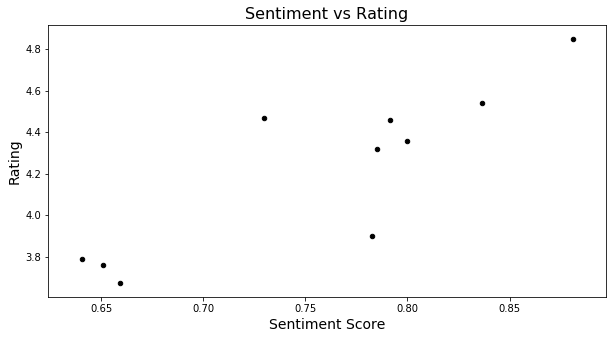

In [80]:
ax = plt.gca()
business_avg_sentiment.plot(kind='scatter',x='avg_sentiment',y='avg_stars', figsize=(10, 5), color='black', ax=ax)

plt.title('Sentiment vs Rating', fontsize=16)
plt.ylabel('Rating', fontsize=14)
plt.xlabel('Sentiment Score', fontsize=14)

plt.show()

In [81]:
X = business_avg_sentiment[['avg_sentiment']]
y = business_avg_sentiment[['avg_stars']]

reg = LinearRegression().fit(X, y)

print('r^2 :', reg.score(X, y))
print('correlation :', reg.score(X, y)**(1/2))

r^2 : 0.7488331150937708
correlation : 0.8653514402217002
